In [311]:
import sys
import numpy as np
from scipy.stats import mode
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
sys.path.append('./utils')

In [312]:
import consts_

### Загрузка данных. Удаление ненужного столбца.

In [313]:
df = pd.read_csv('data/train.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,96218,2012-06-19,2012-06-21,182,38,red,17,109.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
1,96219,2012-06-19,2012-06-21,557,38,red,1,129.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
2,96220,2012-06-19,2012-06-21,90,38,red,24,69.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,0
3,96221,2012-06-19,2012-06-21,1,38,red,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
4,96222,2012-06-19,2012-06-21,1,37+,red,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1


### Поиск пропусков в данных.

In [314]:
df.replace('?', np.nan, inplace=True)
has_null = df.isna().any()
is_null = df.isna().sum()
for col in df.columns:
    print(f"{col:<15} {'True ' if has_null[col] else 'False'}  {is_null[col]}")

orderItemID     False  0
orderDate       False  0
deliveryDate    True   29848
itemID          False  0
size            False  0
color           True   143
manufacturerID  False  0
price           False  0
customerID      False  0
salutation      False  0
dateOfBirth     True   39675
state           False  0
creationDate    False  0
returnShipment  False  0


In [315]:
# Приведение столбцов с датами к дате
df['orderDate'] = pd.to_datetime(df['orderDate'], format='%Y-%m-%d', errors='coerce')
df['deliveryDate'] = pd.to_datetime(df['deliveryDate'], format='%Y-%m-%d', errors='coerce')
df['dateOfBirth'] = pd.to_datetime(df['dateOfBirth'], format='%Y-%m-%d', errors='coerce')
df['creationDate'] = pd.to_datetime(df['creationDate'], format='%Y-%m-%d', errors='coerce')
# Вставка моды в пропуски цвета
df['color'] = df['color'].fillna(df['color'].mode()[0])

In [316]:
# Убираем оставшиеся пропуски
df['deliveryDate'] = df['deliveryDate'].fillna(df['deliveryDate'].median())
df['dateOfBirth'] = df['dateOfBirth'].fillna(df['dateOfBirth'].median())

Поправка. Дата рождения будет заполнена медианой, потому что похуй, после этого посмотреть есть ли кто-то, кто живёт аномально долго. Если такие есть - вырезать. ✓

С датой отправки и доставки всё просто. Заполнить медианным значением и удалить те строки, где доставлено раньше чем заказано.

### МММ хуета - строим графики в очередной раз

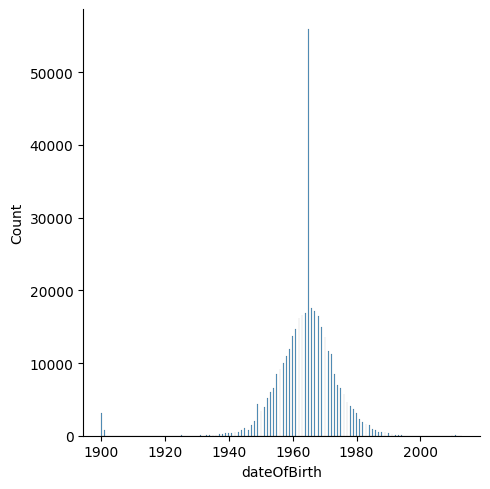

In [317]:
sns.displot(df['dateOfBirth'].dt.year)
# steam moment

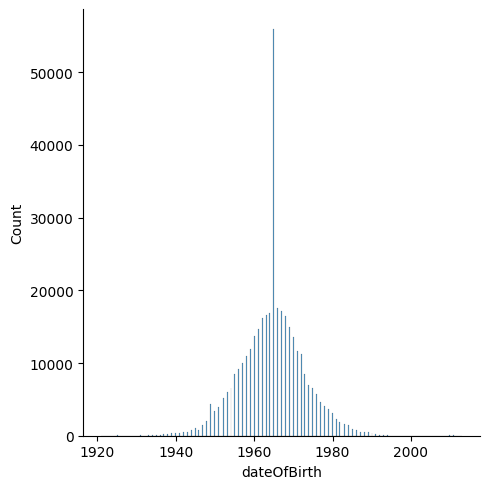

In [318]:
df = df.loc[df['dateOfBirth'].dt.year > 1920]
sns.displot(df['dateOfBirth'].dt.year)

In [319]:
df['ageHuman'] = ((dt.datetime.now() - df['dateOfBirth']).dt.days / 365).astype(int)
df['ageAccount'] = ((dt.datetime.now() - df['creationDate']).dt.days / 365).astype(int)

In [320]:
df_0 = df.loc[df['returnShipment'] == 0]
df_1 = df.loc[df['returnShipment'] == 1]

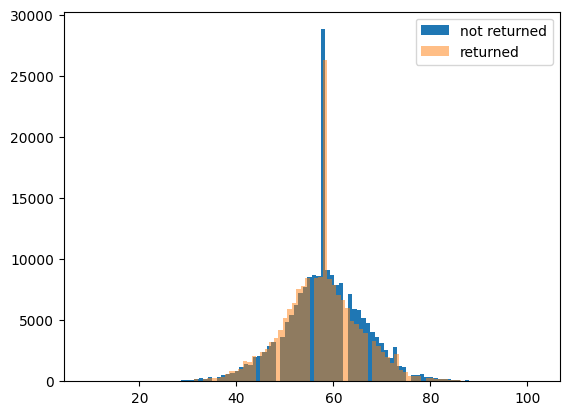

In [321]:
plt.hist(df_0['ageHuman'], bins=100, label='not returned')
plt.hist(df_1['ageHuman'], bins=100, label='returned', alpha=0.5)
plt.legend()

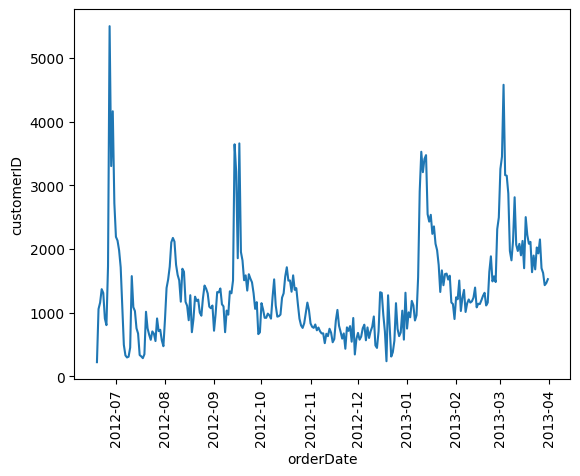

In [322]:
sns.lineplot(df.groupby('orderDate')['customerID'].count())
plt.xticks(rotation = 90);

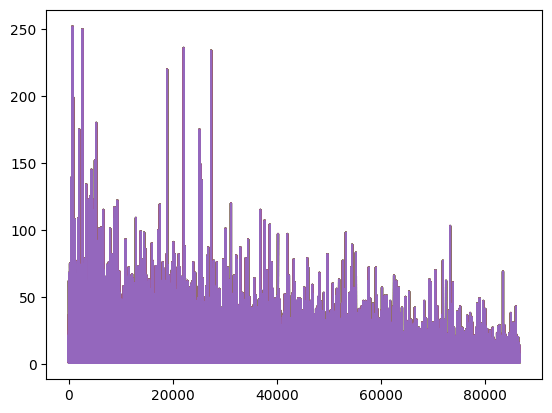

In [323]:
plt.plot(df.groupby('customerID').count());

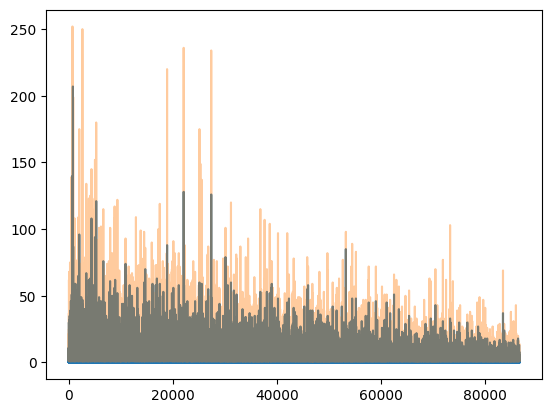

In [324]:
plt.plot(df.groupby('customerID')['returnShipment'].sum())
plt.plot(df.groupby('customerID')['returnShipment'].count(), alpha=0.4);

58.0


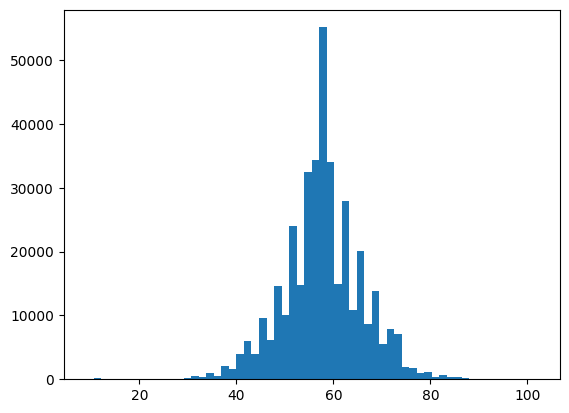

In [325]:
plt.hist(df['ageHuman'], bins=60);
print(df['ageHuman'].median())

### ГруппировОчка

In [326]:
df.groupby('itemID')['price'].agg(['mean', 'median', 'min', 'max', 'sum'])

,mean,median,min,max,sum
itemID,,,,,
1,97.104724,119.90,59.90,119.90,24664.60
2,22.343820,19.90,19.90,39.90,3977.20
3,20.122222,19.90,19.90,39.90,1811.00
4,79.123301,79.90,64.90,129.90,16299.40
5,40.346429,39.90,34.90,69.90,15815.80
...,...,...,...,...,...
3067,59.950000,59.95,59.95,59.95,59.95
3068,64.950000,64.95,64.95,64.95,129.90
3069,0.000000,0.00,0.00,0.00,0.00


### Обработка цветов

In [327]:
def color_to_RGB(x):
    try:
        x = tuple(colors.to_rgb(consts_.COLORMAP[x.strip()]))
    except (ValueError, KeyError):
        x = x
    return x


In [328]:
df['color'] = df['color'].apply(lambda x: color_to_RGB(x))

In [329]:
df = df[df['color'].apply(lambda x: isinstance(x, tuple))]

In [330]:
df['state'].unique()

array(['Baden-Wuerttemberg', 'Saxony', 'Lower Saxony', 'Bavaria',
       'North Rhine-Westphalia', 'Schleswig-Holstein', 'Hesse',
       'Brandenburg', 'Rhineland-Palatinate', 'Hamburg', 'Thuringia',
       'Mecklenburg-Western Pomerania', 'Berlin', 'Saxony-Anhalt',
       'Bremen', 'Saarland'], dtype=object)

### Если заказ пришёл в прошлом, значит он не пришёл человеку

In [331]:
df = df.loc[df['deliveryDate'] >= df['orderDate']]
# Есть какие-то "полученные товары", но можно считать, учитывая их количество, что это накрутка
# Таким образом данные, где доставлено раньше, чем заказано, можно убрать

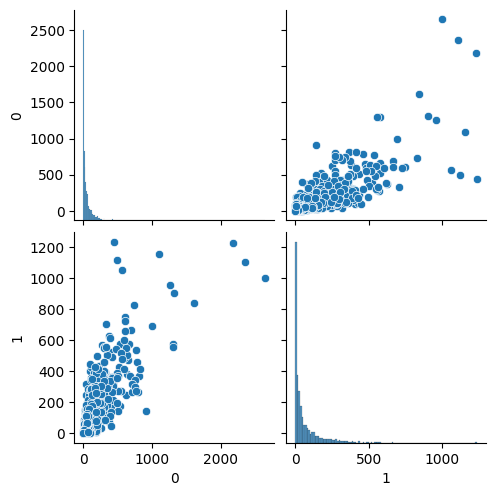

In [332]:
sns.pairplot(df.groupby('itemID')['returnShipment'].value_counts().unstack())

In [333]:
df = df.reset_index(drop=True)

### OneHot + PCA для размера

In [334]:
encoder = OneHotEncoder()
encoded_feature = encoder.fit(df[['size']])
new_size = encoded_feature.transform(df[['size']])

In [335]:
pca = PCA(n_components=10)
reduced_features = pca.fit_transform(new_size.toarray())

In [336]:
df_reduced_features = pd.DataFrame(reduced_features)
df_reduced_features.rename(columns={0: 'reduced_size1',
                                    1: 'reduced_size2',
                                    2: 'reduced_size3',
                                    3: 'reduced_size4',
                                    4: 'reduced_size5',
                                    5: 'reduced_size6',
                                    6: 'reduced_size7',
                                    7: 'reduced_size8',
                                    8: 'reduced_size9',
                                    9: 'reduced_size10',}, inplace=True)
df_reduced_features

,reduced_size1,reduced_size2,reduced_size3,reduced_size4,reduced_size5,reduced_size6,reduced_size7,reduced_size8,reduced_size9,reduced_size10
0,-0.030694,-0.067862,-0.021213,-0.093506,-0.024397,-0.009282,0.030591,0.100229,0.829599,-0.436450
1,-0.030694,-0.067862,-0.021213,-0.093506,-0.024397,-0.009282,0.030591,0.100229,0.829599,-0.436450
2,-0.030694,-0.067862,-0.021213,-0.093506,-0.024397,-0.009282,0.030591,0.100229,0.829599,-0.436450
3,-0.030694,-0.067862,-0.021213,-0.093506,-0.024397,-0.009282,0.030591,0.100229,0.829599,-0.436450
4,-0.008780,-0.017401,-0.004326,-0.016692,-0.003143,-0.001121,0.003435,0.008508,0.018227,0.018138
...,...,...,...,...,...,...,...,...,...,...
362685,-0.026601,-0.057570,-0.017098,-0.072842,-0.017219,-0.006406,0.020568,0.060212,0.221570,0.800825
362686,-0.026601,-0.057570,-0.017098,-0.072842,-0.017219,-0.006406,0.020568,0.060212,0.221570,0.800825
362687,-0.049484,-0.121441,-0.052232,-0.311798,0.848116,0.085996,-0.150949,-0.156571,-0.143719,-0.090683
362688,-0.008909,-0.017668,-0.004397,-0.016975,-0.003200,-0.001141,0.003498,0.008669,0.018596,0.018531


### Разбить закодированный цвет на составляющие в разные столбцы

In [337]:
df[['R', 'G', 'B']] = pd.DataFrame(df['color'].tolist(), index=df.index)
df = df.drop('color', axis=1)

### Добавляем в основной датафрейм закодированные сжатые размеры

In [338]:
# df = df.drop('size', axis=1)
df = pd.concat([df, df_reduced_features], axis=1)

In [339]:
df.groupby('orderItemID')['itemID'].value_counts().unstack().dropna(thresh=2)
# В каждом id заказа только 1 товар

itemID,1,2,3,4,5,6,7,8,9,10,...,3060,3061,3062,3064,3065,3066,3067,3068,3069,3070
orderItemID,,,,,,,,,,,,,,,,,,,,,


Нормализовать возраст человека. Распределён нормально.

In [340]:
standart_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
df['ageHuman'] = standart_scaler.fit_transform(df[['ageHuman']])
df['ageAccount'] = minmax_scaler.fit_transform(df[['ageAccount']])

In [341]:
df = df.drop('orderItemID', axis=1)

### OneHot State

In [345]:
df = pd.concat([df, pd.get_dummies(df['state'], dtype=float)], axis=1)

In [346]:
df.head()

,orderDate,deliveryDate,itemID,size,manufacturerID,price,customerID,salutation,dateOfBirth,state,...,Hesse,Lower Saxony,Mecklenburg-Western Pomerania,North Rhine-Westphalia,Rhineland-Palatinate,Saarland,Saxony,Saxony-Anhalt,Schleswig-Holstein,Thuringia
0,2012-06-19,2012-06-21,182,38,17,109.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-06-19,2012-06-21,557,38,1,129.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-06-19,2012-06-21,90,38,24,69.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-06-19,2012-06-21,1,38,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-06-19,2012-06-21,1,37+,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Самый популярный товар у покупателя

In [382]:
# Подсчет числа покупок товара
purchase_count = df.groupby(['customerID', 'itemID']).size().reset_index(name='purchase_count')

# Подсчет суммы значений столбца "returnShipment"
return_sum = df.groupby(['customerID', 'itemID'])['returnShipment'].sum().reset_index(name='return_sum')

# Объединение данных по столбцам "customerID" и "itemID"
result = pd.merge(purchase_count, return_sum, on=['customerID', 'itemID'], how='left')

# Вычисление числа покупок товара путем вычитания суммы из подсчета
result['purchase_count'] = result['purchase_count'] - result['return_sum']

# Нахождение индексов строк с максимальными значениями "purchase_count" для каждой группы "customerID"
max_indices = result.groupby('customerID')['purchase_count'].idxmax()

# Получение строк с максимальными значениями "purchase_count" для каждого пользователя
most_purchased_items = result.loc[max_indices]

# Вывод результата
print(most_purchased_items)


        customerID  itemID  purchase_count  return_sum
2                6    1404               2           2
15               9    1613               1           0
25              11     966               1           0
28              13    1415               2           0
34              15    1544               1           0
...            ...     ...             ...         ...
273607       86559      39               0           1
273613       86604    2438               1           0
273616       86606    2334               2           0
273620       86609    2334               2           0
273621       86610    2669               1           0

[51657 rows x 4 columns]
